#새로운 feature로 시도

In [313]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [314]:
import pandas as pd
import numpy as np

##올바르지 않은

In [315]:
path1='/content/drive/Shareddrives/데이터 청년 캠퍼스/젓가락질 데이터/새 젓가락질 데이터/excel 파일/vector/newdata_all_0818_ver1_final.xlsx'

In [316]:
data= pd.read_excel(path1)

In [317]:
#data.drop(['z_4-3','z_7-6','z_8-7','z_11-10','z_12-11','z_15-14','z_16-15'], axis=1)

In [318]:
vector0= data[data['y']==0]

In [319]:
len(vector0)

458

In [320]:
vector0.drop(['y','image'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [321]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
vector0_=scaler.fit_transform(vector0)

In [322]:
vector0_

array([[0.16947118, 0.15200896, 0.39047881, ..., 0.49671975, 0.23276515,
        0.3817695 ],
       [0.19417795, 0.19715325, 0.46824719, ..., 0.58014562, 0.21369782,
        0.29625631],
       [0.2048083 , 0.19527092, 0.35136478, ..., 0.64454432, 0.21425322,
        0.23642054],
       ...,
       [0.66370591, 0.        , 0.36603886, ..., 0.        , 0.34821892,
        0.36221497],
       [0.65769222, 0.15687445, 0.78970941, ..., 0.27839815, 0.19667352,
        0.03452838],
       [0.79786835, 0.1956777 , 0.5280553 , ..., 0.26505607, 0.36226694,
        0.00995019]])

##올바른

In [323]:
vector1= data[data['y']==1]

In [324]:
vector1.drop(['y','image'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [325]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
vector1_=scaler.fit_transform(vector1)

In [326]:
vector1_

array([[0.34297359, 0.33590423, 0.47927196, ..., 0.77611054, 0.18572155,
        0.45988883],
       [0.39394204, 0.34102994, 0.43739652, ..., 0.848468  , 0.07543671,
        0.03400301],
       [0.3890838 , 0.30953464, 0.38405601, ..., 0.76987515, 0.11564082,
        0.20920615],
       ...,
       [0.24580877, 0.13024552, 0.44814649, ..., 0.02438274, 0.09955553,
        0.00931198],
       [0.23363373, 0.11018369, 0.48977205, ..., 0.01220599, 0.11457109,
        0.02301508],
       [0.22160929, 0.12950693, 0.3862413 , ..., 0.09434509, 0.1038719 ,
        0.00305066]])

#LSTM

데이터셋 분리

In [327]:
from sklearn.model_selection import train_test_split

In [328]:
vector0 = np.array(vector0_)
vector1 = np.array(vector1_)
len(vector0), len(vector1)
vector0.shape, vector1.shape

((458, 23), (730, 23))

In [329]:
#수정필요,,,?

x0_train = vector0[:int(0.7*len(vector0))]
x0_test = vector0[int(0.7*len(vector0)):]

In [330]:
x0_train.shape, x0_test.shape

((320, 23), (138, 23))

In [331]:
x1_train = vector1[:int(0.7*len(vector1))]
x1_test = vector1[int(0.7*len(vector1)):]

In [332]:
x1_train.shape, x1_test.shape

((510, 23), (220, 23))

비정상 :1, 정상: 0

In [333]:
x0_test_tot = np.hstack((x0_test, np.ones(x0_test.shape[0]).reshape(-1,1)))
x1_test_tot = np.hstack((x1_test, np.zeros(x1_test.shape[0]).reshape(-1,1)))
test_tot = np.vstack((x0_test_tot, x1_test_tot))

In [334]:
x_test, x_valid, y_test, y_valid = train_test_split(test_tot[:,:-1], test_tot[:,-1], test_size=0.3)

In [335]:
print(x_test.shape, x_valid.shape, y_test.shape)

(250, 23) (108, 23) (250,)


데이터 차원 변경

In [336]:
x1_train =x1_train.reshape(x1_train.shape[0],1,x1_train.shape[1])
x_test =x_test.reshape(x_test.shape[0],1,x_test.shape[1])
x_valid =x_valid.reshape(x_valid.shape[0],1,x_valid.shape[1])

In [337]:
print(x1_train.shape,x_test.shape,x_valid.shape)

(510, 1, 23) (250, 1, 23) (108, 1, 23)


신경망 구축

In [338]:
from keras import regularizers
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector

In [339]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    # return_sequences 가 True면 각 time_steps의 셀이 모두 출력으로 내보냄 , False 면 최종 셀만 출력으로 내보냄
    L1 = LSTM(32, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(16, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(16, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(32, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [340]:
model = autoencoder_model(x1_train)
model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 1, 23)]           0         
_________________________________________________________________
lstm_60 (LSTM)               (None, 1, 32)             7168      
_________________________________________________________________
lstm_61 (LSTM)               (None, 16)                3136      
_________________________________________________________________
repeat_vector_15 (RepeatVect (None, 1, 16)             0         
_________________________________________________________________
lstm_62 (LSTM)               (None, 1, 16)             2112      
_________________________________________________________________
lstm_63 (LSTM)               (None, 1, 32)             6272      
_________________________________________________________________
time_distributed_15 (TimeDis (None, 1, 23)             759

In [341]:
model = autoencoder_model(x1_train)
model.compile(optimizer='adam',loss='mse')

In [342]:
epochs=25
batch_size=5
callbacks=[EarlyStopping(monitor='val_loss',patience=5)]

history = model.fit(x1_train, x1_train, epochs=epochs, batch_size= batch_size,callbacks = callbacks, validation_split=0.05).history

Epoch 1/25
97/97 [==============================] - 7s 27ms/step - loss: 0.1558 - val_loss: 0.0567
Epoch 2/25
97/97 [==============================] - 2s 20ms/step - loss: 0.0300 - val_loss: 0.0470
Epoch 3/25
97/97 [==============================] - 2s 20ms/step - loss: 0.0260 - val_loss: 0.0484
Epoch 4/25
97/97 [==============================] - 2s 20ms/step - loss: 0.0255 - val_loss: 0.0455
Epoch 5/25
97/97 [==============================] - 2s 21ms/step - loss: 0.0252 - val_loss: 0.0456
Epoch 6/25
97/97 [==============================] - 2s 20ms/step - loss: 0.0245 - val_loss: 0.0449
Epoch 7/25
97/97 [==============================] - 2s 20ms/step - loss: 0.0194 - val_loss: 0.0287
Epoch 8/25
97/97 [==============================] - 2s 20ms/step - loss: 0.0137 - val_loss: 0.0220
Epoch 9/25
97/97 [==============================] - 2s 20ms/step - loss: 0.0121 - val_loss: 0.0155
Epoch 10/25
97/97 [==============================] - 2s 21ms/step - loss: 0.0112 - val_loss: 0.0114
Epoch 11/

In [343]:
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

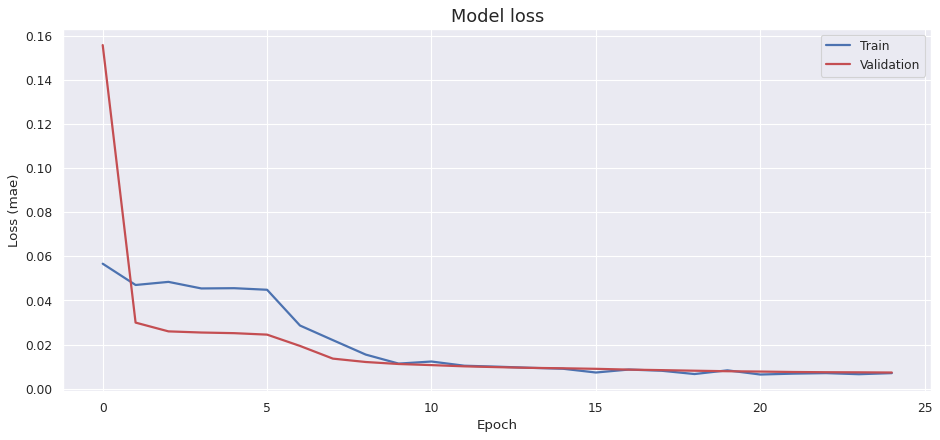

In [344]:
# 학습 손실 시각화
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['val_loss'], 'b', label='Train', linewidth=2)
ax.plot(history['loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [345]:
from sklearn import metrics

precision:  0.7692307692307693 , recall:  0.7692307692307693
threshold:  0.033027291591721616


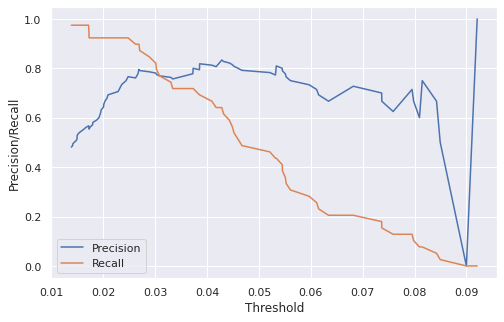

In [346]:
#검증 데이터 입력
predictions_3d = model.predict(x_valid)
predictions = predictions_3d.reshape(predictions_3d.shape[0], predictions_3d.shape[2])
x_valid_ = x_valid.reshape(x_valid.shape[0], x_valid.shape[2])

#재구성 손실 값 도출
mse = np.mean(np.power(x_valid_ - predictions, 2), axis = 1)

error_df = pd.DataFrame({'Reconstruction_error':mse, 'True_class': y_valid})

precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

#모델 최적의 threshold 값 찾기
best_cnt_dic = abs(precision_rt - recall_rt)
threshold_fixed = threshold_rt[np.argmin(best_cnt_dic)]
print('precision: ', precision_rt[np.argmin(best_cnt_dic)], ', recall: ', recall_rt[np.argmin(best_cnt_dic)])
print('threshold: ', threshold_fixed)

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label = 'Precision')
plt.plot(threshold_rt, recall_rt[1:], label = 'Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

모델 성능 평가

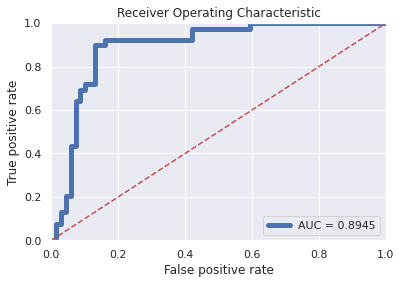

In [347]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_valid, mse)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label = 'AUC = %0.4f' % roc_auc, linewidth=5)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1],'r--')
plt.xlim([-0.001,1])
plt.ylim([0,1.001])
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

accuracy:  [0.86]


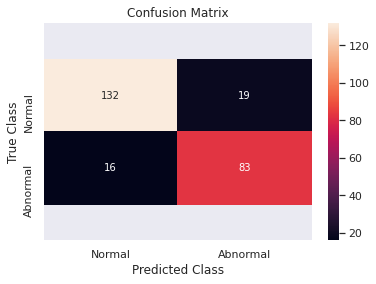

In [348]:
test_predictions_3d = model.predict(x_test)
test_predictions = test_predictions_3d.reshape(test_predictions_3d.shape[0], test_predictions_3d.shape[2])
x_test_ = x_test.reshape(x_test.shape[0], x_test.shape[2])
mse = np.mean(np.power(x_test_ - test_predictions, 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_test})

pred_y = [1 if e > threshold_fixed else 0 for e in error_df['Reconstruction_error'].values]
conf_matrix = metrics.confusion_matrix(error_df['True_class'], pred_y)

accuracy = (conf_matrix[0][0]+ conf_matrix[1][[1]])/conf_matrix.sum()
print('accuracy: ',accuracy)

sns.heatmap(conf_matrix, xticklabels=['Normal','Abnormal'], yticklabels=['Normal', 'Abnormal'], annot=True, fmt='d', annot_kws={'size':10})
b,t = plt.ylim()
b+=0.5
t-=0.5
plt.ylim(b,t)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class'); plt.ylabel('True Class')
plt.show()

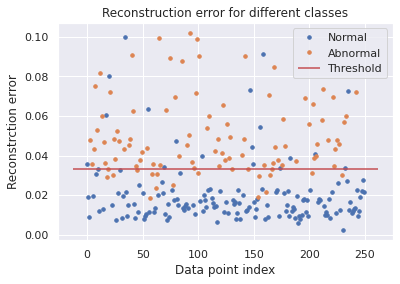

In [349]:
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
  ax.plot(group.index, group.Reconstruction_error, marker = 'o', ms=3.5, linestyle='',
          label='Abnormal' if name ==1 else 'Normal')

ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors ='r', zorder=100, label ='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")  
plt.ylabel("Reconstrction error")
plt.xlabel("Data point index")
plt.show()